In [1]:
# as mentioned in README, based on fastai/fastbook 
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Retrieving training images

Used Bing API search (there is a free 1 week trial) to retrieve via keywords:

    - bengal cat (! not bengal cats, this gives mainly footbal images!)
    - regular cats
    - cartoon cats

https://www.microsoft.com/en-us/bing/apis/bing-web-search-api

## From Data to DataLoaders

In [3]:
path = Path('images')

this sets up the connection with the API key and tests an example image:

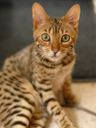

In [9]:
key = os.environ.get('AZURE_SEARCH_KEY', 'YOUR_API_KEY_HERE')
results = search_images_bing(key, 'bengal cat')
ims = results.attrgot('content_url')
len(ims)

dest = 'images/tmp.jpg'
download_url(ims[5], dest)
im = Image.open(dest)
im.to_thumb(128,128)

below is run 3 times, for each keyword once. One could of course do this more elegantly in a loop.

In [11]:
o = ('bengals')
dest = (path/o)
results = search_images_bing(key, 'bengal cat')
download_images(dest, urls=results.attrgot('content_url'))

Here it starts getting interesting, the dataloader portion, used for data cleanup, etc:

In [47]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [48]:
dls = cats.dataloaders(path)

Despite the interesting tools that come with fastai (book), I did a manual image cleaning, 2 rounds, otherwise   too much false one. follwing section has multiple ways of looking at the data and ensuring the quality:

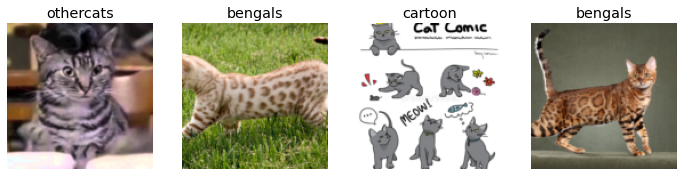

In [49]:
dls.valid.show_batch(max_n=4, nrows=1)

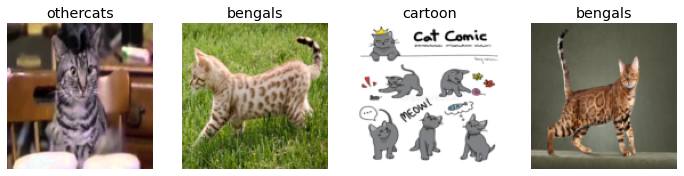

In [50]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

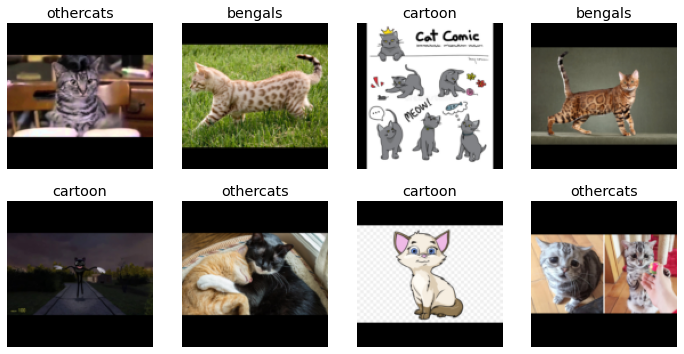

In [51]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

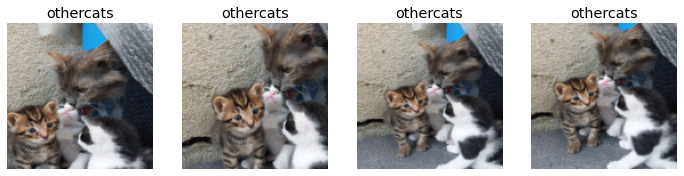

In [52]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

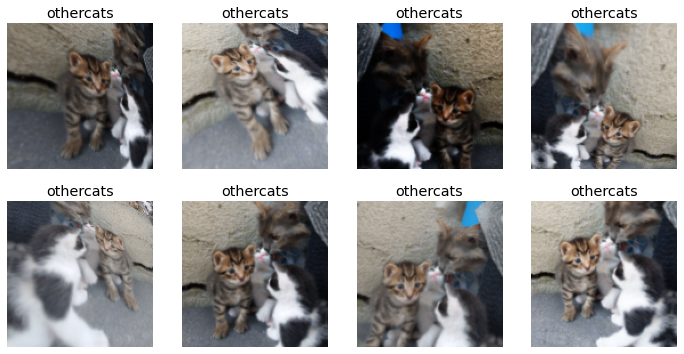

In [53]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

here we finally go with the model creation

In [54]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

This model uses resnet18, i.e. 18 layers deep. Sufficient for this type of playing around.

In [55]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.402183,0.329910,0.087500,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.384943,0.297959,0.062500,00:06
1,0.293537,0.288863,0.062500,00:06
2,0.211069,0.323468,0.062500,00:06
3,0.165102,0.330658,0.075000,00:06


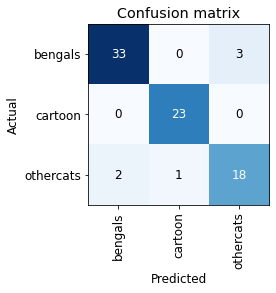

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

as the confusion matrix shows, ok, but not perfect.

below one way of looking for example the worst examples:

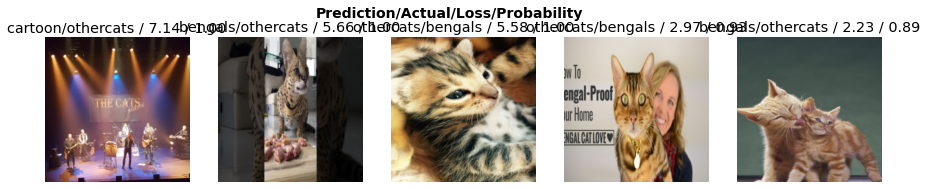

In [57]:
interp.plot_top_losses(5, nrows=1)

Now this is a clever way of doing some clean up (offered by fastai). but I don't find it works too well (e.g. when moving an image to another class there could be a clash in file-names....).

In [58]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [59]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

i.e. finally, we are closing in to the finish line.

In [60]:
learn.export()

In [61]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [62]:
learn_inf = load_learner(path/'export.pkl')

a small test:

In [64]:
learn_inf.predict('images/tmp.jpg')

('bengals', tensor(0), tensor([9.9996e-01, 3.9035e-05, 7.8649e-07]))

In [65]:
learn_inf.dls.vocab

(#3) ['bengals','cartoon','othercats']

### That's it!